In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
import seaborn as sns
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models #type: ignore
 
### 0. Data Loading and Labeling Structure - with winter dates
train_tensor = np.load("train_tensor.npy")
validation_tensor = np.load("validation_tensor.npy")

### 0. Data Loading and Labeling Structure - without winter dates
train_tensor_p1 = train_tensor[27:27+299, :, :, :8]
train_tensor_p2 = train_tensor[27+299+67:27+299+67+295, :, :, :8]
train_tensor = np.concatenate((train_tensor_p1, train_tensor_p2), axis=0)
validation_tensor = validation_tensor[26:26+188, :, :, :8]

T = 1  # Number of time steps to look back
features = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']

In [3]:
def standardizing_tensor(tensor):
    tensor = tensor.copy()
    stored_means = np.zeros((tensor.shape[0], tensor.shape[3]))
    stored_stds = np.zeros((tensor.shape[0], tensor.shape[3]))
    # Standardize per time step and per channel over all spatial locations (ignoring NaNs)
    for t in range(tensor.shape[0]):
        for c in range(tensor.shape[3]):
            slice_ = tensor[t, :, :, c]
            mean = np.nanmean(slice_)
            std = np.nanstd(slice_)
            if not np.isfinite(std) or std == 0:
                continue
            tensor[t, :, :, c] = (slice_ - mean) / std
            stored_means[t, c] = mean
            stored_stds[t, c] = std
    return tensor, stored_means, stored_stds

def unstandardize_with_stats(tensor_standardized, means, stds):
    # Invert standardization using the same stats; skip invalid stds
    tensor = tensor_standardized.copy()
    T, H, W, C = tensor.shape
    for t in range(T):
        for c in range(C):
            std = stds[t, c]
            if not np.isfinite(std) or std == 0:
                continue
            tensor[t, :, :, c] = tensor[t, :, :, c] * std + means[t, c]
    return tensor

# Apply the updated function
train_tensor, train_means, train_stds = standardizing_tensor(train_tensor)
validation_tensor, validation_means, validation_stds = standardizing_tensor(validation_tensor)

In [4]:
def create_shifted_frames(data, T, target_channels):
    N, H, W, C = data.shape
    n_samples = N - T

    x = np.zeros((n_samples, T, H, W, C), dtype=np.float32)
    y = np.zeros((n_samples, H, W, target_channels), dtype=np.float32)

    for i in range(n_samples):
        x[i] = data[i:i + T]
        y[i] = data[i + T, :, :, :target_channels]
    return x, y

x_train, y_train = create_shifted_frames(train_tensor, T, target_channels=8)
x_val, y_val_true = create_shifted_frames(validation_tensor, T, target_channels=8)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val_true shape: {y_val_true.shape}")

x_train shape: (593, 1, 63, 173, 8)
y_train shape: (593, 63, 173, 8)
x_val shape: (185, 1, 63, 173, 8)
y_val_true shape: (185, 63, 173, 8)


In [5]:
def cnn_temporal_attention_model(
    T, H, W, C_in=8,      # input: T days of H×W and C_in channels
    emb_dim=128,           # size of per-frame embedding
    num_heads=4,           # attention heads
    C_out=8):              # output channels
    inp = layers.Input(shape=(T, H, W, C_in))

    # 1) Per-frame CNN encoder 
    # TimeDistributed makes the same CNN apply to each of the T frames.
    x = layers.TimeDistributed(layers.Conv2D(64, 1, padding="same", activation="relu"))(inp)
    x = layers.TimeDistributed(layers.MaxPool2D(2))(x)   # → (batch, T, H/2, W/2, 32)
    x = layers.BatchNormalization()(x)
    x = layers.TimeDistributed(layers.Conv2D(128, 3, padding="same", activation="relu"))(x)
    x = layers.TimeDistributed(layers.MaxPool2D(2))(x)   # → (batch, T, H/4, W/4, 64)
    x = layers.BatchNormalization()(x)

    # 2) Flatten spatial dims → per-frame vector 
    # Now x has shape (batch, T, Hf, Wf, 64).  We collapse Hf×Wf×64 → emb_dim
    x = layers.TimeDistributed(layers.Flatten())(x)     # → (batch, T, Hf*Wf*64)
    x = layers.TimeDistributed(layers.Dense(emb_dim))(x)# → (batch, T, emb_dim)

    # 3) Temporal self-attention 
    # We let each of the T tokens attend to all T tokens.
    attn_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=emb_dim//num_heads)(query=x, value=x, key=x)
    # attn_out.shape = (batch, T, emb_dim)

    # 4) Pick the “last” time step’s output as your context 
    # (you could also pool or learn a special [CLS] token)
    context = layers.Lambda(lambda t: t[:, -1, :])(attn_out)  # → (batch, emb_dim)

    # 5) Decode back to spatial map 
    # a) Expand vector → a small feature map
    x = layers.Dense((H//4)*(W//4)*64, activation="relu")(context)
    x = layers.Reshape((H//4, W//4, 64))(x)
    # b) Upsample back to full H×W
    # After your last Conv2DTranspose(32, ...)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)  # 15x43 -> 30x86
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)  # 30x86 -> 60x172
    x = layers.Conv2DTranspose(16, kernel_size=(4, 2), strides=1,padding="valid", activation="relu")(x)  # 60×172 → 63×173

    # c) Final 1×1 conv for 8 output variables
    out = layers.Conv2D(C_out, 1, padding="same", activation="linear")(x)

    return models.Model(inputs=inp, outputs=out)


# Usage 
model = cnn_temporal_attention_model(T=T, H=63, W=173, C_in=8, emb_dim=256, num_heads=4, C_out=8)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

### 2. Train the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val_true), epochs=10, batch_size=16)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 63,     │          0 │ -                 │
│ (InputLayer)        │ 173, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 1, 63,     │        576 │ input_layer[0][0] │
│ (TimeDistributed)   │ 173, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 1, 31, 86, │          0 │ time_distributed… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1, 31, 86, │        256 │ time_distributed… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 1, 31, 86, │     73,856 │ batch_normalizat… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 1, 15, 43, │          0 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 15, 43, │        512 │ time_distributed… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 1, 82560)  │          0 │ batch_normalizat… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 1, 256)    │ 21,135,616 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 256)    │    263,168 │ time_distributed… │
│ (MultiHeadAttentio… │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 41280)     │ 10,608,960 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 15, 43,    │          0 │ dense_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 30, 86,    │     18,464 │ reshape[0][0]     │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 60, 172,   │      4,624 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 63, 173,   │      2,064 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 63, 173,   │        136 │ conv2d_transpose… │
│                     │ 8)                │            │                 

 Total params: 32,108,232 (122.48 MB)

 Trainable params: 32,107,848 (122.48 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - loss: 0.8835 - mae: 0.5779 - val_loss: 0.7494 - val_mae: 0.5094
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - loss: 0.5525 - mae: 0.4431 - val_loss: 0.5855 - val_mae: 0.4333
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - loss: 0.4563 - mae: 0.3832 - val_loss: 0.4957 - val_mae: 0.3837
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - loss: 0.4132 - mae: 0.3546 - val_loss: 0.4719 - val_mae: 0.3755
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - loss: 0.3894 - mae: 0.3420 - val_loss: 0.4116 - val_mae: 0.3434
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - loss: 0.3476 - mae: 0.3147 - val_loss: 0.4411 - val_mae: 0.3515
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - loss: 0.3369 - mae: 0.3049 - val_loss: 0.4184 - val_mae: 0.3464
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - loss: 0.3195 - mae: 0.2969 - val_loss: 0.3928 - val_mae: 0.3286
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - l

In [6]:
### 3. Inference: Evaluate full validation set
val_loss, val_mae = model.evaluate(x_val, y_val_true)
print(f"Validation loss: {val_loss}")
print(f"Validation MAE: {val_mae}")

y_val_pred = model.predict(x_val)
y_val_true = y_val_true[T:, :, :, :8]  # Ensure y_val_true has the same shape as y_val_pred
y_val_pred = y_val_pred[T:, :, :, :8]  # Ensure y_val_pred has the same shape as y_val_true
print(f"y_val_true shape: {y_val_true.shape}")
print(f"y_val_pred shape: {y_val_pred.shape}")

y_val_pred = unstandardize_with_stats(y_val_pred, validation_means, validation_stds)
y_val_true = unstandardize_with_stats(y_val_true, validation_means, validation_stds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.3879 - mae: 0.3222
Validation loss: 0.3882756531238556
Validation MAE: 0.3226257562637329
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
y_val_true shape: (184, 63, 173, 8)
y_val_pred shape: (184, 63, 173, 8)


# Validation

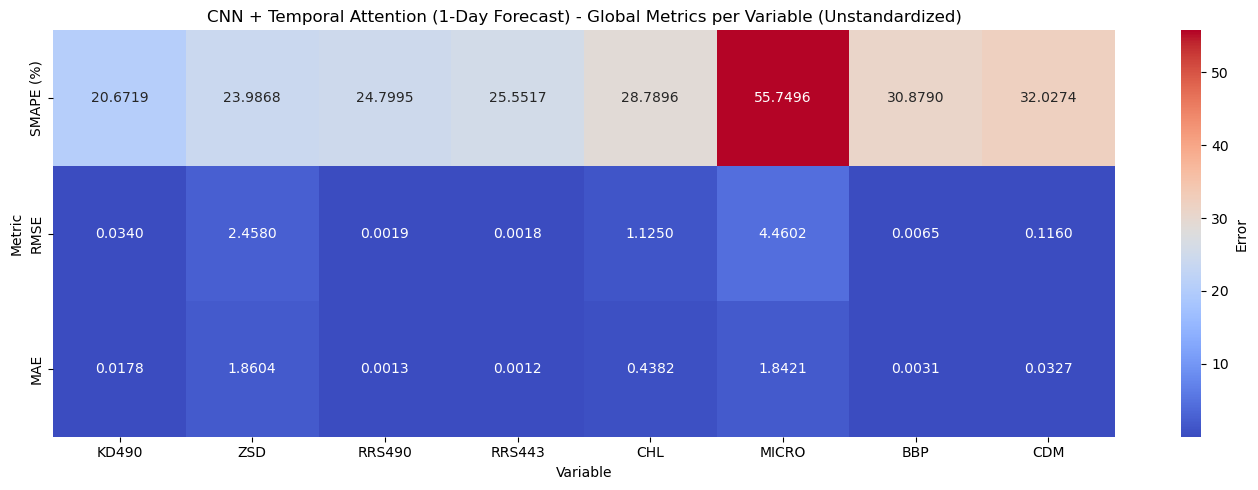

In [7]:
### 4. Evaluation
features = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']

eps = 1e-8
smape = 100 * np.mean(
    np.abs(y_val_pred - y_val_true) /
    (np.abs(y_val_pred) + np.abs(y_val_true) + eps),
    axis=(0, 1, 2)
)
rmse = np.sqrt(np.mean((y_val_pred - y_val_true) ** 2, axis=(0, 1, 2)))
mae  = np.mean(np.abs(y_val_pred - y_val_true), axis=(0, 1, 2))


# Build DataFrame

metrics_df = pd.DataFrame({
    'SMAPE (%)': smape,
    'RMSE': rmse,
    'MAE': mae
}, index=features).T  # transpose to match your heatmap format


# Plot heatmap

plt.figure(figsize=(14,5))
sns.heatmap(metrics_df, annot=True, fmt=".4f", cmap="coolwarm", cbar_kws={'label': 'Error'})
plt.title("CNN + Temporal Attention (1-Day Forecast) - Global Metrics per Variable (Unstandardized)")
plt.xlabel("Variable")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()

First date: 2024-01-31
Last date: 2024-08-05


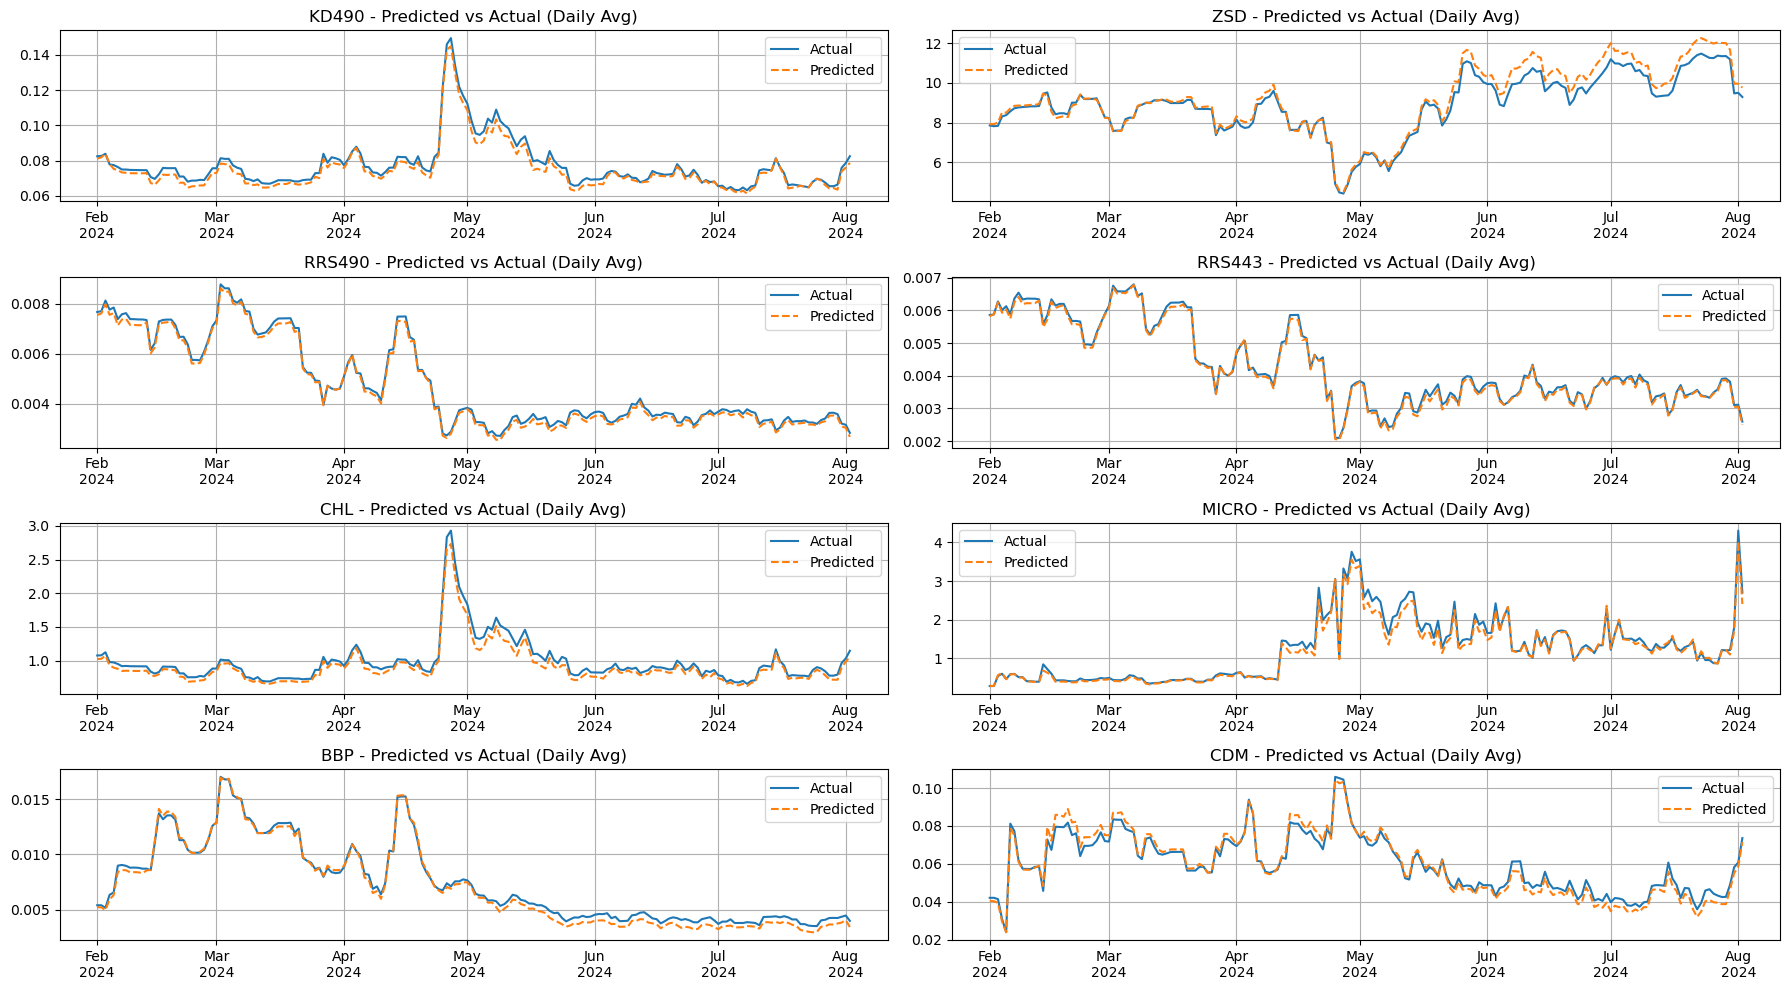

In [8]:
import datetime

start_date = datetime.date(2024, 1, 1)
first_index = 30
last_index = 30 + 188 - 1  # 211 - 1 = 210

first_date = start_date + datetime.timedelta(days=first_index)
last_date = start_date + datetime.timedelta(days=last_index)
val_dates = [first_date + datetime.timedelta(days=i) for i in range((last_date - first_date).days + 1)]

print("First date:", first_date)
print("Last date:", last_date)

# Daily spatial means plot

seq_len = 1  # or whatever your model uses

pred_means = y_val_pred.mean(axis=(1, 2)) 
#true_means = y_val_true.mean(axis=(1, 2))
val_dates_seq = val_dates[seq_len: seq_len + len(pred_means)]

import matplotlib.dates as mdates
fig, axs = plt.subplots(4, 2, figsize=(18, 10)); axs = axs.flatten()
for i, var in enumerate(features):
    valid = y_val_true[:, :, :, i] != 0
    actual = np.where(valid, y_val_true[:, :, :, i], np.nan)
    true_means = np.nanmean(actual, axis=(1, 2))
    axs[i].plot(val_dates_seq, true_means, label="Actual")
    axs[i].plot(val_dates_seq, pred_means[:, i], label="Predicted", linestyle="--")
    axs[i].set_title(f"{var} - Predicted vs Actual (Daily Avg)")
    axs[i].xaxis.set_major_locator(mdates.MonthLocator())
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axs[i].grid(True); axs[i].legend()
plt.tight_layout(); plt.show()

# Testing

In [9]:
test_tensor = np.load("test_tensor.npy")

test_tensor, test_means, test_stds = standardizing_tensor(test_tensor)

x_test, y_test_true = create_shifted_frames(test_tensor, T, target_channels=8)
y_test_pred = model.predict(x_test)
y_test_true = y_test_true[T:, :, :, :8]  # Ensure y_test
y_test_pred = y_test_pred[T:, :, :, :8]  # Ensure y_test_pred has the same shape as y_test_true
y_test_pred = unstandardize_with_stats(y_test_pred, test_means, test_stds)
y_test_true = unstandardize_with_stats(y_test_true, test_means, test_stds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step 


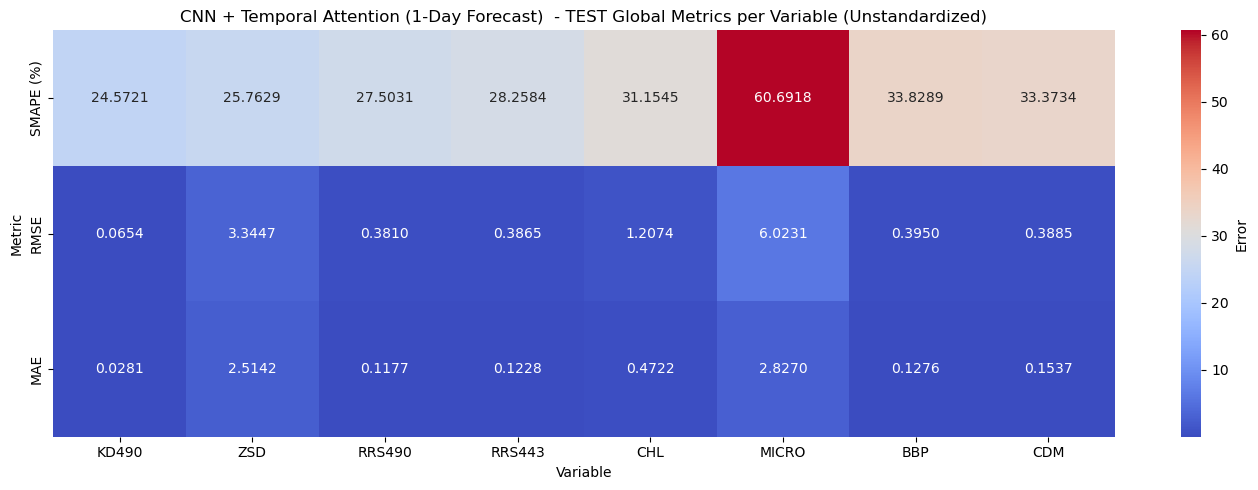

In [10]:
### 4. Evaluation
features = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']

eps = 1e-8
smape = 100 * np.mean(
    np.abs(y_test_pred - y_test_true) /
    (np.abs(y_test_pred) + np.abs(y_test_true) + eps),
    axis=(0, 1, 2)
)
rmse = np.sqrt(np.mean((y_test_pred - y_test_true) ** 2, axis=(0, 1, 2)))
mae  = np.mean(np.abs(y_test_pred - y_test_true), axis=(0, 1, 2))


# Build DataFrame

metrics_df = pd.DataFrame({
    'SMAPE (%)': smape,
    'RMSE': rmse,
    'MAE': mae
}, index=features).T  # transpose to match your heatmap format


# Plot heatmap

plt.figure(figsize=(14,5))
sns.heatmap(metrics_df, annot=True, fmt=".4f", cmap="coolwarm", cbar_kws={'label': 'Error'})
plt.title("CNN + Temporal Attention (1-Day Forecast)  - TEST Global Metrics per Variable (Unstandardized)")
plt.xlabel("Variable")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()

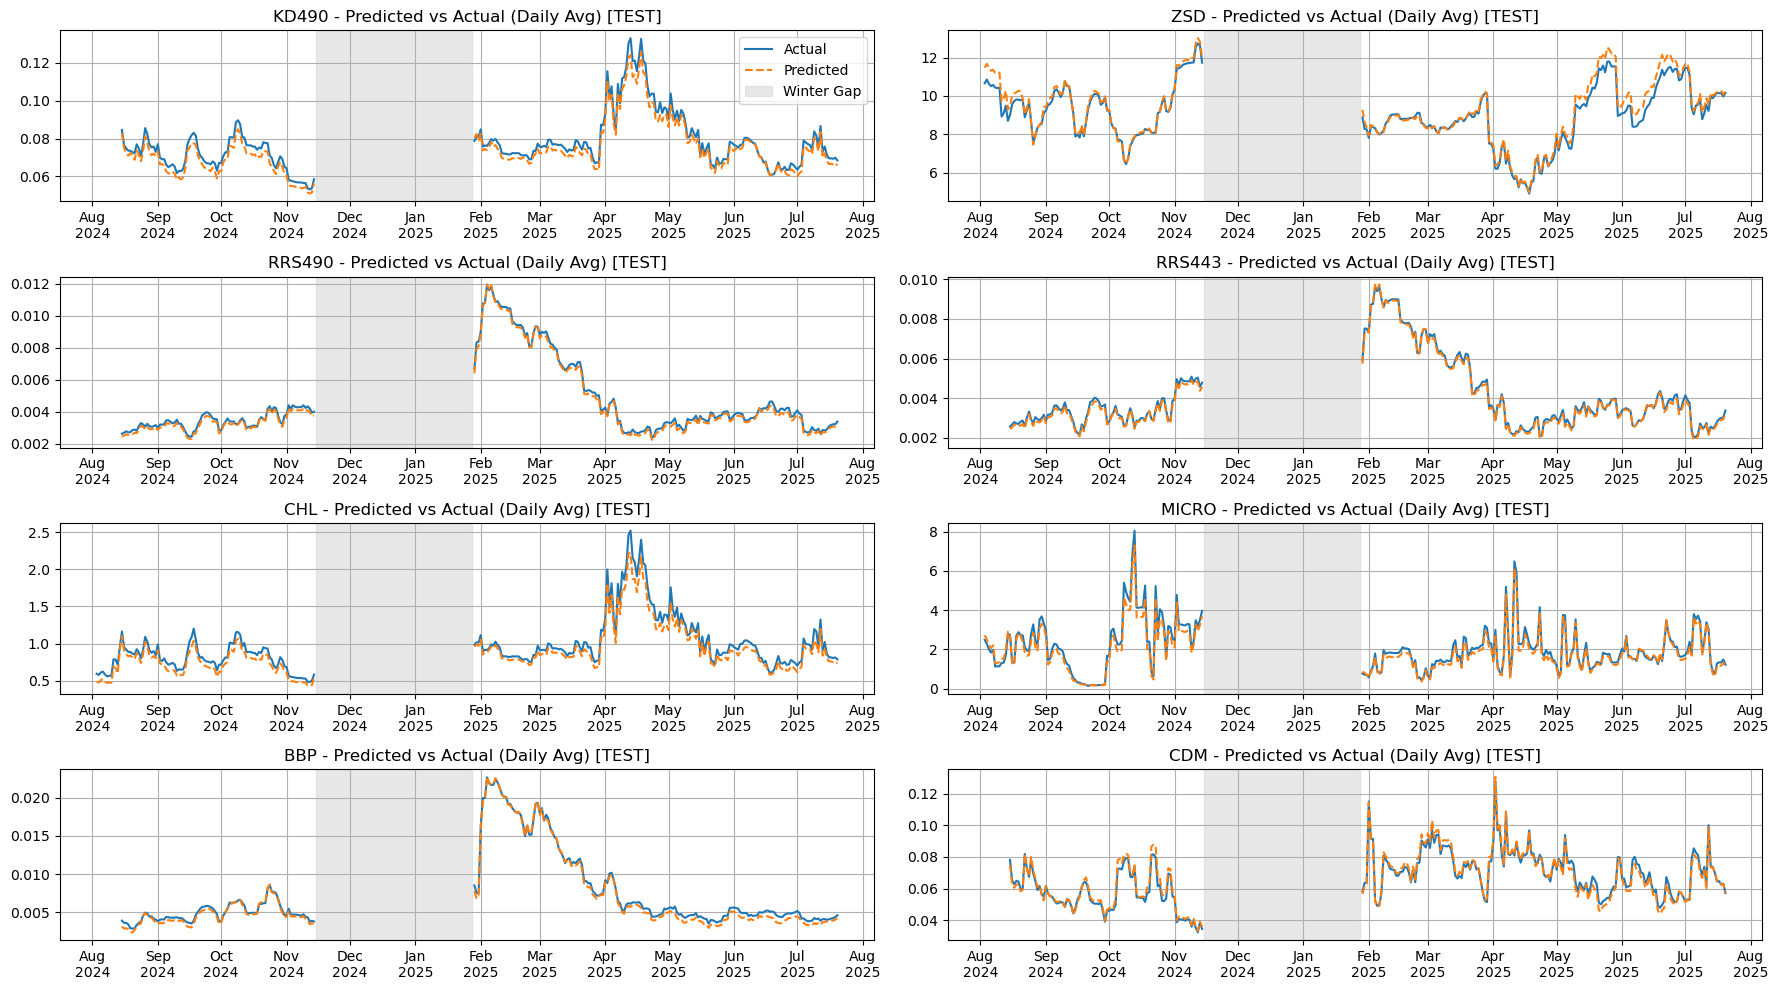

First pred date: 2024-08-03 Last pred date: 2025-07-20


In [ ]:
import datetime as dt
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib.dates as mdates

seq_len = 1          # your model context
horizon = 1          # 1-step ahead; set 0 if “same-day” labels
S = y_test_pred.shape[0]
F = y_test_pred.shape[1] if y_test_pred.ndim == 2 else y_test_pred.shape[-1]

# x-axis dates aligned to TEST predictions
first_pred_date = pd.Timestamp("2024-08-02 00:00:00") + pd.Timedelta(days=(seq_len - 1 + horizon))
dates = pd.date_range(start=first_pred_date, periods=S, freq="D")

# daily spatial means
true_means = y_test_true.mean(axis=(1, 2))   # (S, F)
pred_means = y_test_pred.mean(axis=(1, 2))   # (S, F)

# break lines in winter gaps
winter_gaps = [(pd.Timestamp("2024-11-15"), pd.Timestamp("2025-01-28"))]
in_gap = np.zeros(S, dtype=bool)
for s, e in winter_gaps:
    in_gap |= (dates >= s) & (dates <= e)

true_plot = true_means.copy();  pred_plot = pred_means.copy()
true_plot[in_gap, :] = np.nan
pred_plot[in_gap, :] = np.nan

# which variables should be non-negative (default: all)
nonneg_vars = set(features[:F])       # e.g. {"KD490","ZSD","RRS490","RRS443","CHL","MICRO","BBP","CDM"}
eps = 0.0                             # tolerance; use -1e-9 if you have tiny numerical noise
for i, var in enumerate(features[:F]):
    if var not in nonneg_vars:
        continue
    # first index where both true & pred are non-negative
    valid = (true_means[:, i] >= eps) & (pred_means[:, i] >= eps)
    if np.any(valid):
        first_ok = np.argmax(valid)   # first True
        true_plot[:first_ok, i] = np.nan
        pred_plot[:first_ok, i] = np.nan
    else:
        # everything negative → hide entire series to avoid misleading lines
        true_plot[:, i] = np.nan
        pred_plot[:, i] = np.nan

# plot
fig, axs = plt.subplots(4, 2, figsize=(18, 10), sharex=True); axs = axs.ravel()
for i, var in enumerate(features[:F]):
    axs[i].plot(dates, true_plot[:, i], label="Actual")
    axs[i].plot(dates, pred_plot[:, i], ls="--", label="Predicted")
    axs[i].set_title(f"{var} - Predicted vs Actual (Daily Avg) [TEST]")
    axs[i].xaxis.set_major_locator(mdates.MonthLocator())
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axs[i].grid(True)
    for s, e in winter_gaps:
        axs[i].axvspan(s, e, color="lightgrey", alpha=0.5, label="Winter Gap" if i == 0 else None)

# show x-axis date labels on ALL subplots
for ax in axs:
    ax.tick_params(axis="x", which="both", labelbottom=True)
    # (optional) ensure formatter is applied even if sharex hides it
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

axs[0].legend()
plt.subplots_adjust(hspace=0.35)   # a bit more room for the dates
plt.tight_layout()
plt.show()